In [14]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,ranksums,wilcoxon

In [15]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [16]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 200
M=10

In [17]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,1+num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [18]:
# def get_df(idx_resample,perm):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,q,elbos,resampled_subj_list = pickle.load(f)
    
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df,model

In [19]:
import rle
import random

def get_trans_mat(df,shuffle_z:bool=False):
    PI = np.zeros((K,K))
    for z in df['discrete_states'].values:

        z_perm = z.copy()

        if shuffle_z == True:
            values,counts = rle.encode(z_perm)
            encoding = list(zip(values, counts))
            random.shuffle(encoding)
            values,counts = zip(*encoding)
            z_perm = rle.decode(values=values, counts=counts)

        for st_from,st_to in zip(z_perm[:-1],z_perm[1:]):
            PI[st_from,st_to] += 1
    PI = PI / np.expand_dims(PI.sum(axis=1),axis=1)
    return PI

In [20]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [21]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [22]:
true_PIs = {}
null_PIs = {}

for idx_resample in tqdm(range(1,num_resamples+1)):    
    true_PI = get_trans_mat(all_dfs[idx_resample],shuffle_z=False)
    null_PI = get_trans_mat(all_dfs[idx_resample],shuffle_z=True)

    state_mask = state_masks[idx_resample]
    for idx_state in range(K):
        if state_mask[idx_state] == 1:
            true_PI[idx_state,:] = np.nan
            true_PI[:,idx_state] = np.nan
            null_PI[idx_state,:] = np.nan
            null_PI[:,idx_state] = np.nan

    true_PIs[idx_resample] = true_PI
    null_PIs[idx_resample] = null_PI
    


100%|██████████| 200/200 [00:25<00:00,  7.78it/s]


In [23]:
true_pis = np.stack(true_PIs.values(),axis=0)
null_pis = np.stack(null_PIs.values(),axis=0)
mean_pi = np.nanmean(true_pis,axis=0)

In [24]:
# true_pis1 = true_pis[:,[0,1,2,3,5],:]
# true_pis1 = true_pis1[:,:,[0,1,2,3,5]]
# null_pis1 = null_pis[:,[0,1,2,3,5],:]
# null_pis1 = null_pis1[:,:,[0,1,2,3,5]]
# mean_pi1 = mean_pi[[0,1,2,3,5],:]
# mean_pi1 = mean_pi1[:,[0,1,2,3,5]]
# mean_pi1 = mean_pi1 / np.expand_dims(mean_pi1.sum(axis=1),axis=1)

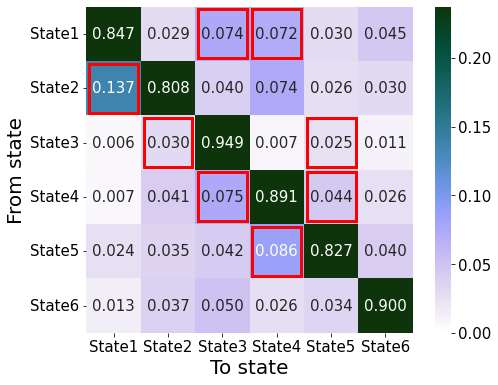

In [25]:
import cmasher as cmr
state_names = [f"State{i}" for i in range(1,K+1)]
# state_names = ['post-shock','shock','far','retreat','near','???']
# state_names1 = ['post-shock','shock','far','retreat','near']
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
sns.heatmap(mean_pi,annot=True,fmt='0.3f',vmin=0,vmax=mean_pi.max()/4,cmap=cmr.horizon_r,ax=ax,annot_kws={'size':15},square=True)
significant_transitions = []
trans_list = []
for i in range(K):
    for j in range(K):
        true_vals = true_pis[:,i,j]
        null_vals = null_pis[:,i,j]
        true_vals = true_vals[~np.isnan(true_vals)]
        null_vals = null_vals[~np.isnan(null_vals)]
        pval = ranksums(
            true_vals, null_vals,
            # equal_var=False,
            alternative='greater',
        ).pvalue
        if pval<0.05/((K)*(K)):
            trans_list.append(f"{i}{j}")
            # ax.add_patch(patches.Circle((j+0.5,i+0.5),0.4,linewidth=3, edgecolor='red',facecolor='none'))
            ax.add_patch(patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=3, edgecolor='red',facecolor='none'))
            significant_transitions.append(f'{i}{j}')
ax.set_xticklabels(state_names,rotation=0,fontsize=15)
ax.set_yticklabels(state_names,rotation=0,fontsize=15)
ax.set_xlabel('To state',fontsize=20)
ax.set_ylabel('From state',fontsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
fig.savefig(f'figures/fig_state_transition_matrix_significant_transitions_K{K}.jpg',dpi=600,bbox_inches='tight')

In [26]:
significant_transitions

['02', '03', '10', '21', '24', '32', '34', '43']